In [1]:
import hashlib
import os
import math
import zipfile
import warnings
import pandas as pd
import numpy as np
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
#from sklearn.grid_search import GridSearchCV

#ignoring the filter difference
warnings.filterwarnings("ignore")


In [2]:
DATA_PATH = ("./student_data")
#download the data files
DOWNLOAD_ROOT = "https://analyse.kmi.open.ac.uk/open_dataset/download"
if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)
tgz_path = os.path.join(DATA_PATH, "student.zip")
urllib.request.urlretrieve(DOWNLOAD_ROOT, tgz_path)
student_file = zipfile.ZipFile(tgz_path)
student_file.extractall(path=DATA_PATH)
student_file.close()


In [4]:
IMAGES_PATH = ("./data_figures")
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
#load the data
studentInfo_data = pd.read_csv('./student_data/studentInfo.csv')
studentAssessment = pd.read_csv('./student_data/studentAssessment.csv')
assessment = pd.read_csv('./student_data/assessments.csv')
studentVle = pd.read_csv('./student_data/studentVle.csv')
courses = pd.read_csv('./student_data/courses.csv')
studentVle = pd.read_csv('./student_data/studentVle.csv')
studentRegistration = pd.read_csv('./student_data/studentRegistration.csv')

#mix the studentAssessment data and assessment data into one data set to form up a score average in the final data set easily
new_mix_score = pd.merge(studentAssessment, assessment,  left_on='id_assessment', right_on='id_assessment')

In [4]:
#shows the information for each student ID
studentInfo_data["id_student"].value_counts()

584077     5
609605     4
624126     4
610287     4
596620     4
          ..
511693     1
290521     1
2588379    1
632544     1
591873     1
Name: id_student, Length: 28785, dtype: int64

In [5]:
#sum up and average the score and create a new csv file (with the score)
need_head = True
studentInfo_module_AAA = studentInfo_data.loc[(studentInfo_data["code_module"] == 'AAA' )]
student_module_code_list = studentInfo_data["code_module"].unique()
for module_code in student_module_code_list:
    student_data_with_the_module_code = studentInfo_data.loc[(studentInfo_data["code_module"] == module_code )]
    code_presentation_list = student_data_with_the_module_code["code_presentation"].unique()
    for presentation_code in code_presentation_list:
        student_data_with_the_presentation_code = student_data_with_the_module_code.loc[(student_data_with_the_module_code["code_presentation"] == presentation_code )]
        data_of_the_assessments_id_with_score = new_mix_score.loc[(new_mix_score["code_module"] == module_code) & (new_mix_score["code_presentation"] == presentation_code)]
        data_of_the_sum_click = studentVle.loc[(studentVle["code_module"] == module_code) & (studentVle["code_presentation"] == presentation_code)]
        data_of_the_unregistration = studentRegistration.loc[(studentRegistration["code_module"] == module_code) & (studentRegistration["code_presentation"] == presentation_code)]
        
        student_id_with_certain_module_presentation = student_data_with_the_presentation_code["id_student"].unique()
        new_score_data = {'id_student': [], 'score': []}
        new_vle_data = {'id_student': [], 'sum_click': []}
        new_registration_data = {'id_student': [], 'register': []}
        #print(student_id_with_certain_module_presentation)
        for student in student_id_with_certain_module_presentation:
            #print(student)
            new_score_data['id_student'].append(student)
            new_vle_data['id_student'].append(student)
            new_registration_data['id_student'].append(student)
            total_score = 0
            sum_click = 0
            score_data = data_of_the_assessments_id_with_score.loc[(data_of_the_assessments_id_with_score['id_student'] == student)]
            click_data = data_of_the_sum_click.loc[(data_of_the_sum_click['id_student'] == student)]
            if math.isnan(data_of_the_unregistration.loc[(data_of_the_unregistration['id_student'] == student)]['date_unregistration']):
                new_registration_data['register'].append(1)
            else:
                new_registration_data['register'].append(0)
            new_score_data['score'].append(round(score_data['score'].sum()/len(score_data), 3))
            new_vle_data['sum_click'].append(click_data['sum_click'].sum())
            
        new_score_data = pd.DataFrame(new_score_data)
        new_vle_data = pd.DataFrame(new_vle_data)
        new_registration_data = pd.DataFrame(new_registration_data)
        new_with_score = pd.merge(student_data_with_the_presentation_code, new_score_data, left_on='id_student', right_on='id_student')
        new_with_click = pd.merge(new_with_score, new_vle_data, left_on='id_student', right_on='id_student')
        new_with_register = pd.merge(new_with_click, new_registration_data, left_on='id_student', right_on='id_student')
        
        new_with_register.to_csv('./student_data/new_total_studentInfo.csv', mode='a', index=False, header=need_head)
        need_head = False


In [6]:
#Load the new data (with the score and vle)
new_total_studentInfo = pd.read_csv('./student_data/new_total_studentInfo.csv')
new_total_studentInfo.sample(5)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score,sum_click,register
31482,GGG,2014B,623602,F,North Region,A Level or Equivalent,50-60%,0-35,0,30,N,Pass,88.222,499,1
25112,FFF,2013J,581656,M,South West Region,A Level or Equivalent,60-70%,0-35,0,60,Y,Pass,73.333,3158,1
4457,BBB,2013J,610449,F,East Anglian Region,A Level or Equivalent,90-100%,0-35,0,120,Y,Withdrawn,NaN,0,0
11285,CCC,2014J,551397,M,Ireland,A Level or Equivalent,50-60%,0-35,0,30,N,Pass,85.667,4560,1
21509,EEE,2014J,634367,M,West Midlands Region,A Level or Equivalent,80-90%,35-55,1,30,N,Pass,93.000,5651,1


Saving figure sum_click_and_score


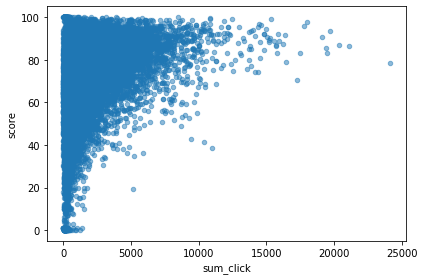

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
#Show the scatter diagram of the sum_click and score data
click_score = new_total_studentInfo.drop(columns=["code_module","code_presentation", "id_student", "gender", "region", "highest_education", "imd_band", "age_band", "num_of_prev_attempts", "studied_credits", "disability", "final_result"])
click_score.sample(5)
click_score.plot(kind="scatter", x="sum_click", y="score", alpha=0.5, sharex=False)
save_fig("sum_click_and_score")

In [6]:
#delete the useless data
new_total_studentInfo.drop([ 'id_student', 'num_of_prev_attempts'], axis = 1, inplace=True)
new_total_studentInfo.sample(5)

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,studied_credits,disability,final_result,score,sum_click,register
9188,CCC,2014B,M,Scotland,HE Qualification,80-90%,0-35,60,N,Pass,67.000,710,1
28611,FFF,2014J,M,East Midlands Region,A Level or Equivalent,90-100%,0-35,120,N,Fail,90.250,848,1
27626,FFF,2014B,M,South Region,A Level or Equivalent,50-60%,0-35,60,N,Pass,78.667,3307,1
3075,BBB,2013J,F,South Region,A Level or Equivalent,80-90%,35-55,60,N,Pass,62.400,210,1
17337,DDD,2014B,F,East Anglian Region,A Level or Equivalent,30-40%,0-35,60,Y,Withdrawn,51.250,776,0


In [7]:
#Label Encoding
from sklearn.preprocessing import LabelEncoder
for col in new_total_studentInfo.columns:
    if new_total_studentInfo[col].nunique() == 2:
        le = LabelEncoder()
        le.fit(new_total_studentInfo[col])
        new_total_studentInfo[col] = le.transform(new_total_studentInfo[col])
new_total_studentInfo.sample(5)

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,studied_credits,disability,final_result,score,sum_click,register
25866,FFF,2013J,1,East Anglian Region,A Level or Equivalent,20-30%,0-35,120,0,Pass,75.833,3251,1
32552,GGG,2014J,1,Scotland,Lower Than A Level,10-20,35-55,30,0,Pass,86.429,574,1
10889,CCC,2014J,1,South West Region,HE Qualification,50-60%,35-55,60,0,Pass,85.800,1289,1
32556,GGG,2014J,0,South Region,A Level or Equivalent,70-80%,35-55,30,1,Pass,81.778,597,1
27299,FFF,2014B,1,South Region,Lower Than A Level,40-50%,0-35,120,1,Pass,60.417,3492,1


In [8]:
new_total_studentInfo = new_total_studentInfo.fillna(0)
onehotencoding_data = ['highest_education', 'code_module', 'code_presentation', 'age_band', 'final_result', 'imd_band']
def LabelEncoder(data_encoding, outfile):
    lables = outfile[data_encoding].unique().tolist()
    outfile[data_encoding] = outfile[data_encoding].apply(lambda n: lables.index(n))
    return outfile

for data_set in onehotencoding_data:
    first_decration_data_set = LabelEncoder(data_set, new_total_studentInfo)


first_decration_data_set.sample(5)

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,studied_credits,disability,final_result,score,sum_click,register
15410,3,0,1,Scotland,1,2,2,60,0,2,0.000,53,1
12742,2,1,0,London Region,0,1,2,30,0,0,83.333,1531,1
11336,2,1,0,Scotland,1,10,2,120,1,0,88.000,1409,1
20055,4,0,1,East Midlands Region,1,1,2,60,0,1,0.000,0,0
1914,1,2,0,West Midlands Region,1,2,2,120,0,3,92.444,957,1


In [9]:
#OneHotEncoding
final_data = pd.get_dummies(first_decration_data_set)
#Transfer the final result to the original data
final_data['final_result'].replace(0,'Pass',inplace= True)
final_data['final_result'].replace(1,'Withdrawn',inplace= True)
final_data['final_result'].replace(2,'Fail',inplace= True)
final_data['final_result'].replace(3,'Distinction',inplace= True)
final_data.sample(5)

,code_module,code_presentation,gender,highest_education,imd_band,age_band,studied_credits,disability,final_result,score,...,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region
20947,4,3,1,2,4,2,60,0,Pass,83.75,...,0,0,0,1,0,0,0,0,0,0
5957,1,3,0,1,2,2,60,0,Withdrawn,0.00,...,0,0,0,0,1,0,0,0,0,0
18628,3,1,1,1,9,2,120,0,Withdrawn,0.00,...,0,0,0,0,1,0,0,0,0,0
20207,4,0,1,1,9,2,60,0,Pass,85.00,...,0,0,0,0,0,0,0,0,0,0
2964,1,0,0,2,2,2,60,0,Fail,65.00,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#Devided in to to groups train group and test group
from sklearn.model_selection import train_test_split
y = final_data['final_result'].values
X = final_data.drop(['final_result'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
print("X_train_shape:", X_train.shape, " y_train_shape:", y_train.shape)
print("X_test_shape:", X_test.shape,"  y_test_shape:", y_test.shape)


X_train_shape: (16296, 24)  y_train_shape: (16296,)
X_test_shape: (16297, 24)   y_test_shape: (16297,)


In [52]:
#DECISION TREE
#Through the max depth to train the data
def depth_score_D(d):
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, y_train)
    
    return(clf.score(X_train, y_train), clf.score(X_test, y_test))

In [239]:
#DECISION TREE
def find_the_best_depth_D(depth_list):
    depths = np.arange(depth_list[0], depth_list[1])
    scores = [depth_score_D(d) for d in depths]
    tr_scores = [s[0] for s in scores]
    te_scores = [s[1] for s in scores]
    
    tr_best_index = np.argmax(tr_scores)
    te_best_index = np.argmax(te_scores)
    
    
    
    return [depths[tr_best_index], tr_scores[tr_best_index], depths[te_best_index], te_scores[te_best_index]]

In [240]:
#DECISION TREE
#list each best depth result in each setting range
#group test
depth_group = [[1,50], [1,30], [1,15], [1,10], [1,5], [1,4], [5,10], [5,9], [2,8], [3,7]]
for depth_list in depth_group:
    result = find_the_best_depth_D(depth_list)
    print(depth_list)
    print("BestDepthForTR:", result[0], " bestdepth_train_score:", result[1])
    print("BestDepthForTE:", result[2], " bestdepth_test_score:", result[3])
    
    

[1, 50]
BestDepthForTR: 30  bestdepth_train_score: 1.0
BestDepthForTE: 8  bestdepth_test_score: 0.8117713233790141
[1, 30]
BestDepthForTR: 29  bestdepth_train_score: 0.9998465904732684
BestDepthForTE: 7  bestdepth_test_score: 0.8120781345878503
[1, 15]
BestDepthForTR: 14  bestdepth_train_score: 0.9282810462529724
BestDepthForTE: 7  bestdepth_test_score: 0.8120781345878503
[1, 10]
BestDepthForTR: 9  bestdepth_train_score: 0.84421262560405
BestDepthForTE: 7  bestdepth_test_score: 0.8120269993863776
[1, 5]
BestDepthForTR: 4  bestdepth_train_score: 0.7899823579044258
BestDepthForTE: 4  bestdepth_test_score: 0.7876866434853753
[1, 4]
BestDepthForTR: 3  bestdepth_train_score: 0.7751783385748255
BestDepthForTE: 3  bestdepth_test_score: 0.7770505215790551
[5, 10]
BestDepthForTR: 9  bestdepth_train_score: 0.8442893303674158
BestDepthForTE: 7  bestdepth_test_score: 0.8117201881775414
[5, 9]
BestDepthForTR: 8  bestdepth_train_score: 0.8332438444427399
BestDepthForTE: 7  bestdepth_test_score: 0.81

In [25]:
#DECISION TREE
#using the mini impurity
from sklearn import metrics 
def minsplit_score_D(val):
    clf = DecisionTreeClassifier(criterion='gini', min_impurity_decrease=val)
    clf.fit(X_train, y_train)
    
    return (clf.score(X_train, y_train), clf.score(X_test, y_test))

In [242]:
#DECISION TREE
def find_the_best_min_D (test_range):
    vals = np.linspace(test_range[0], test_range[1], test_range[2])
    scores = [minsplit_score_D(v) for v in vals]
    tr_scores = [s[0] for s in scores]
    te_scores = [s[1] for s in scores]
    
    bestmin_index = np.argmax(te_scores)
    bestscore_te = te_scores[bestmin_index]
    bestscore_tr = tr_scores[bestmin_index]
    
    return [vals[bestmin_index], bestscore_tr, bestscore_te]

In [243]:
#DECISION TREE
#list each best min impurity in each estting range
#group test
range_list = [[0, 0.9, 1000], [0, 0.5, 1000], [0, 0.3, 1000], [0, 0.2, 1000], [0, 0.1, 1000], [0, 0.05, 1000]]

for test_range in range_list:
    result = find_the_best_min_D(test_range)
    print(test_range)
    print("best_min:", result[0], "best_train_score:", result[1],"best_test_score", result[2], "\n")


[0, 0.9, 1000]
best_min: 0.0009009009009009009 best_train_score: 0.8156784536319706 best_test_score 0.8074759664553078 

[0, 0.5, 1000]
best_min: 0.0005005005005005005 best_train_score: 0.8235790442586485 best_test_score 0.8117201881775414 

[0, 0.3, 1000]
best_min: 0.0003003003003003003 best_train_score: 0.8305591777249367 best_test_score 0.8144814890570669 

[0, 0.2, 1000]
best_min: 0.0004004004004004004 best_train_score: 0.8254199585794277 best_test_score 0.81529965228063 

[0, 0.1, 1000]
best_min: 0.0004004004004004004 best_train_score: 0.8254199585794277 best_test_score 0.81529965228063 

[0, 0.05, 1000]
best_min: 0.0004004004004004004 best_train_score: 0.8254199585794277 best_test_score 0.81529965228063 



In [23]:
#DECISION TREE
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier 

model = DecisionTreeClassifier(max_depth=8, min_impurity_decrease=0.0003)
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test_score:", model.score(X_test, y_test))

y_pred = model.predict(X_test)

print("precision:",metrics.precision_score(y_test, y_pred, average="micro"))
print("recall:",metrics.recall_score(y_test, y_pred, average="micro"))
print("F1_score:",metrics.f1_score(y_test, y_pred, average="micro"))

train score: 0.8263377515954835
test_score: 0.8205191139473522
precision: 0.8205191139473522
recall: 0.8205191139473522
F1_score: 0.8205191139473522


In [15]:
#RANDOM FOREST
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier()
clf2.fit(X_train, y_train)
print("train score:", clf2.score(X_train, y_train))
print("test_score:", clf2.score(X_test, y_test))

y_pred = clf2.predict(X_test)

print("precision:",metrics.precision_score(y_test, y_pred, average="micro"))
print("recall:",metrics.recall_score(y_test, y_pred, average="micro"))
print("F1_score:",metrics.f1_score(y_test, y_pred, average="micro"))

train score: 1.0
test_score: 0.8228508314413696
precision: 0.8228508314413696
recall: 0.8228508314413696
F1_score: 0.8228508314413696


In [67]:
#RANDOM FOREST
#Through the max depth to train the data
from sklearn.ensemble import RandomForestClassifier
def depth_score_R(d):
    clf2 = RandomForestClassifier(max_depth=d)
    clf2.fit(X_train, y_train)
    
    return(clf2.score(X_train, y_train), clf2.score(X_test, y_test))

In [68]:
#RANDOM FOREST
def find_the_best_depth_R(depth_list):
    depths = np.arange(depth_list[0], depth_list[1])
    scores = [depth_score_R(d) for d in depths]
    tr_scores = [s[0] for s in scores]
    te_scores = [s[1] for s in scores]
    
    tr_best_index = np.argmax(tr_scores)
    te_best_index = np.argmax(te_scores)
    
    
    
    return [depths[tr_best_index], tr_scores[tr_best_index], depths[te_best_index], te_scores[te_best_index]]

In [70]:
#RANDOM FOREST
#list each best depth result in each setting range
#group test
depth_group = [[1,50], [1,30], [1,15], [1,10], [10,25], [10,20], [10,19], [10,15]]
for depth_list in depth_group:
    result = find_the_best_depth_R(depth_list)
    print(depth_list)
    print("BestDepthForTR:", result[0], " bestdepth_train_score:", result[1])
    print("BestDepthForTE:", result[2], " bestdepth_test_score:", result[3])

[1, 50]
BestDepthForTR: 28  bestdepth_train_score: 1.0
BestDepthForTE: 20  bestdepth_test_score: 0.8239553292016936
[1, 30]
BestDepthForTR: 29  bestdepth_train_score: 1.0
BestDepthForTE: 19  bestdepth_test_score: 0.8232803583481623
[1, 15]
BestDepthForTR: 14  bestdepth_train_score: 0.9059278350515464
BestDepthForTE: 14  bestdepth_test_score: 0.8204577529606676
[1, 10]
BestDepthForTR: 9  bestdepth_train_score: 0.822594501718213
BestDepthForTE: 9  bestdepth_test_score: 0.8067742529299872
[10, 25]
BestDepthForTR: 24  bestdepth_train_score: 0.9987113402061856
BestDepthForTE: 16  bestdepth_test_score: 0.8236485242682703
[10, 20]
BestDepthForTR: 19  bestdepth_train_score: 0.975392734413353
BestDepthForTE: 18  bestdepth_test_score: 0.8238939682150089
[10, 19]
BestDepthForTR: 18  bestdepth_train_score: 0.9645925380461463
BestDepthForTE: 18  bestdepth_test_score: 0.8238939682150089
[10, 15]
BestDepthForTR: 14  bestdepth_train_score: 0.9053141875306824
BestDepthForTE: 14  bestdepth_test_score: 0

In [62]:
#splite the data
#y = data['final_result'].values
#X = data.drop(['final_result'], axis=1).values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

depths = np.arange(5, 40)
scores = [depth_score_R(d) for d in depths]
tr_scores = [s[0] for s in scores]
te_scores = [s[1] for s in scores]
#find the highest score
tr_best_index = np.argmax(tr_scores)
print("bestdepth:", depths[tr_best_index], " bestdepth_train_score:", tr_scores[tr_best_index], '\n')
te_best_index = np.argmax(te_scores)
print("bestdepth:", depths[te_best_index], " bestdepth_test_score:", te_scores[te_best_index], '\n')

bestdepth: 28  bestdepth_train_score: 1.0 

bestdepth: 19  bestdepth_test_score: 0.8225440265079462 



In [11]:
#RANDOM FOREST
#using the mini impurity
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
def minsplit_score_R(val):
    clf3 = RandomForestClassifier(min_impurity_decrease=val)
    clf3.fit(X_train, y_train)
    
    return (clf3.score(X_train, y_train), clf3.score(X_test, y_test))

In [12]:
#RANDOM FOREST
def find_the_best_min_R (test_range):
    vals = np.linspace(test_range[0], test_range[1], test_range[2])
    scores = [minsplit_score_R(v) for v in vals]
    tr_scores = [s[0] for s in scores]
    te_scores = [s[1] for s in scores]
    
    bestmin_index = np.argmax(te_scores)
    bestscore_te = te_scores[bestmin_index]
    bestscore_tr = tr_scores[bestmin_index]
    
    return [vals[bestmin_index], bestscore_tr, bestscore_te]

In [13]:
#RANDOM FOREST
#list each best min impurity in each estting range
#group test
range_list = [[0, 0.9, 1000], [0, 0.5, 1000], [0, 0.3, 1000], [0, 0.2, 1000], [0, 0.1, 1000], [0, 0.05, 1000]]

for test_range in range_list:
    result = find_the_best_min_R(test_range)
    print(test_range)
    print("best_min:", result[0], "best_train_score:", result[1],"best_test_score", result[2], "\n")



[0, 0.9, 1000]
best_min: 0.0 best_train_score: 1.0 best_test_score 0.818371479413389 

[0, 0.5, 1000]
best_min: 0.0 best_train_score: 1.0 best_test_score 0.817266981653065 

[0, 0.3, 1000]
best_min: 0.0 best_train_score: 1.0 best_test_score 0.8180646744799657 

[0, 0.2, 1000]
best_min: 0.0 best_train_score: 1.0 best_test_score 0.819291894213659 

[0, 0.1, 1000]
best_min: 0.0 best_train_score: 1.0 best_test_score 0.8181873964533349 

[0, 0.05, 1000]
best_min: 0.0 best_train_score: 1.0 best_test_score 0.817819230533227 



In [18]:
#RANDOM FOREST
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(max_depth=18, min_impurity_decrease=0.00003)
clf2.fit(X_train, y_train)
print("train score:", clf2.score(X_train, y_train))
print("test_score:", clf2.score(X_test, y_test))

y_pred = clf2.predict(X_test)

print("precision:",metrics.precision_score(y_test, y_pred, average="micro"))
print("recall:",metrics.recall_score(y_test, y_pred, average="micro"))
print("F1_score:",metrics.f1_score(y_test, y_pred, average="micro"))

train score: 0.9092415316642121
test_score: 0.8217463336810455
precision: 0.8217463336810455
recall: 0.8217463336810455
F1_score: 0.8217463336810457
